# A CKAR(2) model
Here we demonstrate the package's utilities in the context of a simple censored and kinked AR(2) model with two regimes.

Consider the model
$$\begin{align}
y_t^*&=\phi_1^*y_{t-1}^*+\phi_1y_{t-1}+\phi_2^*y_{t-1}^*+\phi_2y_{t-1}+\epsilon_t,\\
y_t&=\max\{y_t^*,0\}.
\end{align}$$

This features a 'positive regime' ($y^*\geq0$) and a 'negative regime' ($y^*<0$).

Noting $y_t=\mathbf{1}\{y_t^*\geq0\}y_t^*$, we can rewrite the equation for $y_t^*$ as 

$$y_t^*=(\phi_1^*+\phi_1\mathbf{1}\{y_{t-1}\geq0\})y_{t-1}^*+(\phi_2^*+\phi_2\mathbf{1}\{y_{t-2}\geq0\})y_{t-2}^*+\epsilon_t,$$

where $\mathbf{1}\{y\geq0\}$ is an indicator variable.

In [1]:
using ThresholdStability

function AR2_to_TAR(ϕs, ϕ_stars)
    ϕ1, ϕ2 = ϕs
    ϕ1_star, ϕ2_star = ϕ_stars
    Σ = []
    vals = [1, -1]
    for val1 in vals
        for val2 in vals
            A = zeros(2, 2); A[2, 1] = 1
            A[1, 1] = ϕ1_star + ϕ1 * indicator(val1, 0)
            A[1, 2] = ϕ2_star + ϕ2 * indicator(val2, 0)
            push!(Σ, A)
        end
    end
    return Vector{Array{Float64, 2}}(Σ)
    # NOTE Σ is of form where Σ[1] is with yₜ₋₁,yₜ₋₂ ≥ 0, Σ[2] is with yₜ₋₁ ≥ 0 and yₜ₋₂ < 0, Σ[3] is with yₜ₋₁ < 0 and yₜ₋₂ ≥ 0
    # and Σ[4] is with yₜ₋₁,yₜ₋₂ < 0.
end

AR2_to_TAR (generic function with 1 method)

This yields a set of four $2\times2$ matrices, with each matrix corresponding to a different regime pair (positive-positive, positive-negative, negative-positive and negative-negative.)

For exposition, consider $\phi_1 = 0.4$, $\phi_1^* = 0.2$, $\phi_2=0.2$, and $\phi_2^*=0.1$:

In [2]:
Σ4 = AR2_to_TAR([0.4, 0.2], [0.2, 0.1])

4-element Vector{Matrix{Float64}}:
 [0.6000000000000001 0.30000000000000004; 1.0 0.0]
 [0.6000000000000001 0.1; 1.0 0.0]
 [0.2 0.30000000000000004; 1.0 0.0]
 [0.2 0.1; 1.0 0.0]

The state space constraints for this model are given by `X4`:

In [3]:
E1, E2, E3, E4 = [1 0.; 0 1.], [1 0.; 0 -1.], [-1 0.; 0 1.], [-1 0.; 0 -1.]
D1 = zeros(1,2); D2, D3, D4 = copy(D1), copy(D1), copy(D1)
X4 = [[E1, D1], [E2, D2], [E3, D3], [E4, D4]]

4-element Vector{Vector{Matrix{Float64}}}:
 [[1.0 0.0; 0.0 1.0], [0.0 0.0]]
 [[1.0 0.0; 0.0 -1.0], [0.0 0.0]]
 [[-1.0 0.0; 0.0 1.0], [0.0 0.0]]
 [[-1.0 0.0; 0.0 -1.0], [0.0 0.0]]

and the automaton can be constructed using

In [4]:
G = automaton_constructor(Σ4)

GraphAutomaton{Graphs.SimpleGraphs.SimpleDiGraph{Int64}, Graphs.SimpleGraphs.SimpleEdge{Int64}}(Graphs.SimpleGraphs.SimpleDiGraph{Int64}(8, [[1, 3], [1, 3], [2, 4], [2, 4]], [[1, 2], [3, 4], [1, 2], [3, 4]]), Dict{Graphs.SimpleGraphs.SimpleEdge{Int64}, Dict{Int64, Int64}}(Edge 3 => 2 => Dict(5 => 3), Edge 1 => 1 => Dict(1 => 1), Edge 4 => 2 => Dict(7 => 4), Edge 1 => 3 => Dict(2 => 1), Edge 2 => 1 => Dict(3 => 2), Edge 3 => 4 => Dict(6 => 3), Edge 2 => 3 => Dict(4 => 2), Edge 4 => 4 => Dict(8 => 4)), 8, 8)

We then have the discrete system

In [5]:
s4 = discreteswitchedsystem(Σ4, G, X4)

Hybrid System with automaton GraphAutomaton{Graphs.SimpleGraphs.SimpleDiGraph{Int64}, Graphs.SimpleGraphs.SimpleEdge{Int64}}(Graphs.SimpleGraphs.SimpleDiGraph{Int64}(8, [[1, 3], [1, 3], [2, 4], [2, 4]], [[1, 2], [3, 4], [1, 2], [3, 4]]), Dict{Graphs.SimpleGraphs.SimpleEdge{Int64}, Dict{Int64, Int64}}(Edge 3 => 2 => Dict(5 => 3), Edge 1 => 1 => Dict(1 => 1), Edge 4 => 2 => Dict(7 => 4), Edge 1 => 3 => Dict(2 => 1), Edge 2 => 1 => Dict(3 => 2), Edge 3 => 4 => Dict(6 => 3), Edge 2 => 3 => Dict(4 => 2), Edge 4 => 4 => Dict(8 => 4)), 8, 8)

Alternatively, by substituting for $y_t$ on the first lag only we can produce a set of two $3\times3$ matrices:

In [6]:
function AR2_to_companion(ϕs, ϕ_stars)
    ϕ1, ϕ2 = ϕs
    ϕ1_star, ϕ2_star = ϕ_stars
    Σ = []
    vals = [1, -1]
    for val in vals
        A = zeros(3, 3); A[2, 1] = 1; A[1, 2] = ϕ2_star; A[1, 3] = ϕ2
        A[1, 1] = ϕ1_star + ϕ1 * indicator(val, 0)
        A[3, 1] = indicator(val, 0)
        push!(Σ, A)
    end
    return Vector{Array{Float64, 2}}(Σ)

    # NOTE Σ has form s.t. Σ[1] is with yₜ₋₁ ≥ 0 and Σ[2] is with yₜ₋₁ < 0
end

Σ2 = AR2_to_companion([0.4, 0.2], [0.2, 0.1])
Σ2st = [Σ2[1], Σ2[2], Σ2[1], Σ2[2]]

4-element Vector{Matrix{Float64}}:
 [0.6000000000000001 0.1 0.2; 1.0 0.0 0.0; 1.0 0.0 0.0]
 [0.2 0.1 0.2; 1.0 0.0 0.0; 0.0 0.0 0.0]
 [0.6000000000000001 0.1 0.2; 1.0 0.0 0.0; 1.0 0.0 0.0]
 [0.2 0.1 0.2; 1.0 0.0 0.0; 0.0 0.0 0.0]

`Σ2` consists of the two matrices and `Σ2st` corresponds to the same partitioning of the state space as for `Σ4`.

In this latter case, the automaton is again `G` but the state space constraints are now given by `X2`:

In [7]:
E1, E2, E3, E4 = [1 0 0.; 0 1 0.], [1 0 0.; 0 -1 0.], [-1 0 0.; 0 1 0.], [-1 0 0.; 0 -1 0.]
D1, D3 = [0 1 -1.], [0 1 -1.]; D2, D4 = [0 0 1.], [0 0 1.]
X2 = [[E1, D1], [E2, D2], [E3, D3], [E4, D4]]

4-element Vector{Vector{Matrix{Float64}}}:
 [[1.0 0.0 0.0; 0.0 1.0 0.0], [0.0 1.0 -1.0]]
 [[1.0 0.0 0.0; 0.0 -1.0 0.0], [0.0 0.0 1.0]]
 [[-1.0 0.0 0.0; 0.0 1.0 0.0], [0.0 1.0 -1.0]]
 [[-1.0 0.0 0.0; 0.0 -1.0 0.0], [0.0 0.0 1.0]]

and we construct the discrete switched systems

In [8]:
s2 = discreteswitchedsystem(Σ2)
s2st = discreteswitchedsystem(Σ2st, G, X2)

Hybrid System with automaton GraphAutomaton{Graphs.SimpleGraphs.SimpleDiGraph{Int64}, Graphs.SimpleGraphs.SimpleEdge{Int64}}(Graphs.SimpleGraphs.SimpleDiGraph{Int64}(8, [[1, 3], [1, 3], [2, 4], [2, 4]], [[1, 2], [3, 4], [1, 2], [3, 4]]), Dict{Graphs.SimpleGraphs.SimpleEdge{Int64}, Dict{Int64, Int64}}(Edge 3 => 2 => Dict(5 => 3), Edge 1 => 1 => Dict(1 => 1), Edge 4 => 2 => Dict(7 => 4), Edge 1 => 3 => Dict(2 => 1), Edge 2 => 1 => Dict(3 => 2), Edge 3 => 4 => Dict(6 => 3), Edge 2 => 3 => Dict(4 => 2), Edge 4 => 4 => Dict(8 => 4)), 8, 8)

For our choice of parameter values, this model is stable. In particular, the upper bounds on the joint spectral radius (JSR) of `Σ2`, the constrained joint spectral radius (CJSR) of `(Σ4, G)`, and the state-constrained joint spectral radii (SCJSR) of `(Σ4, G, X4)` and `(Σ2st, G, X2)` all agree in value, up to 4 significant figures:

In [9]:
@show γ_jsr2 = jsr(s2)
@show γ_cjsr4 = cjsr(s4)
@show γ_scjsr4 = sosbound_γ(s4, 2)
@show γ_scjsr2 = sosbound_γ(s2st, 2)

γ_jsr2 = jsr(s2) = 0.9245034044322821


γ_cjsr4 = cjsr(s4) = 0.9245031320476008


γ_scjsr4 = sosbound_γ(s4, 2) = 0.9245079040527346


γ_scjsr2 = sosbound_γ(s2st, 2) = 0.9245079040527346


0.9245079040527346

Indeed, if $\phi_i,\phi_i^*\geq0$ for $i=1,2$, then the model will be stable if and only if
$\sum_{i=1}^2(\phi_i+\phi_i^*)<1$.

As expected, the model appears stable when plotted:

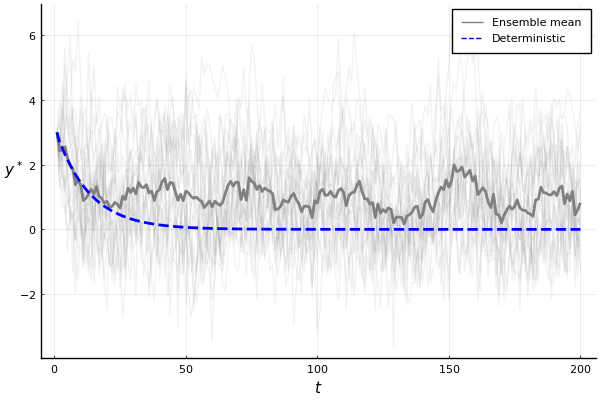

In [10]:
using Plots, Distributions
using LaTeXStrings
pyplot()
function simulate_AR2(y0, Σ, T, σ)  # for companion form
    y = zeros(3, T)
    y[:, 1] = y0
    for t in 1:T-1
        ϵ_t = [rand(Normal(0, σ)), 0., 0.]
        if y[1, t] ≥ 0.
            y[:, t+1] = Σ[1]*y[:, t] + ϵ_t
        else
            y[:, t+1] = Σ[2]*y[:, t] + ϵ_t
        end
    end
    return y
end

function plot_AR2(y0, Σ, T, σ; N = 20, row=1)
    ys = []
    ens_means = zeros(T)
    for i in 1:N
        y = simulate_AR2(y0, Σ, T, σ)
        y = y[row,:]
        push!(ys, y)
        ens_means .+= y
    end
    ens_means ./= N  # ensemble means

    E_y = simulate_AR2(y0, Σ, T, 0.)  # calculating deterministic results
    E_y = E_y[row,:]

    plot(ys, color = :grey, alpha = 0.1, label = "")
    plot!(ens_means, color = :grey, linewidth = 2, label = "Ensemble mean")
    plot!(E_y, color = :blue, linewidth = 2, linestyle = :dash, label = "Deterministic")
    plot!(xlabel=L"t", legend=:topright)
end

plot_AR2(3*ones(3), Σ2, 200, 1)
plot!(ylabel=L"y^*", yguidefontrotation=-90)

Introducing negative parameters, we see that the different upper bounds can diverge.

Consider $\phi_1=0.5$, $\phi_1^*=0.5$, $\phi_2=-0.47$, $\phi_2^*=-0.5$. When plotted, the system appears stable:

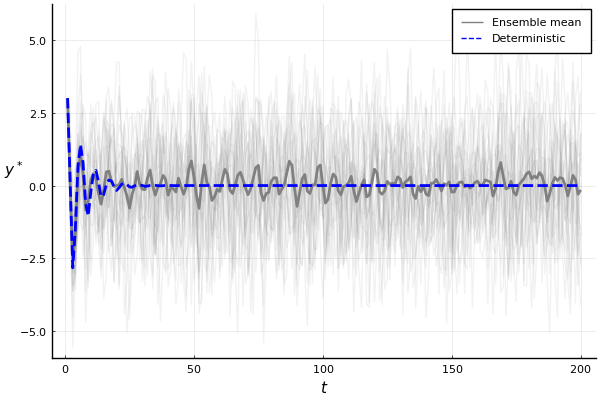

In [11]:
Σ = AR2_to_companion([0.5, -0.47], [0.5, -0.5])
plot_AR2(3*ones(3), Σ, 200, 1, row=1)
plot!(ylabel=L"y^*", yguidefontrotation=-90)

However, this is a case where the conservatism of (the upper bounds on) the JSR and CJSR would prevent us from concluding the system is stable.

In [12]:
Σ = AR2_to_TAR([0.5, -0.47], [0.5, -0.5])
E1, E2, E3, E4 = [1 0.; 0 1.], [1 0.; 0 -1.], [-1 0.; 0 1.], [-1 0.; 0 -1.]
D1 = zeros(1,2); D2, D3, D4 = copy(D1), copy(D1), copy(D1)
X = [[E1, D1], [E2, D2], [E3, D3], [E4, D4]]  # state space constraints
G = automaton_constructor(Σ)
s = discreteswitchedsystem(Σ, G, X)
@show γ_jsr = jsr(s)  # > 1
@show γ_cjsr = cjsr(s)  # > 1

γ_jsr = jsr(s) = 1.1051277501200647


γ_cjsr = cjsr(s) = 1.0010692986341705


1.0010692986341705

However, the upper bound on the SCJSR is less conservative, yielding a bound below 1. We can thus conclude the system is stable.

In [13]:
@show γ_scjsr = sosbound_γ(s, 2)  # < 1

γ_scjsr = sosbound_γ(s, 2) = 0.9848907470703125


0.9848907470703125

Note that (the upper bound on) the SCJSR remains conservative, even if less so than the CJSR or JSR.

For example, consider $\phi_1=\phi_1^*=0.6$ and $\phi_2=\phi_2^*=-0.6$. This appears stable:

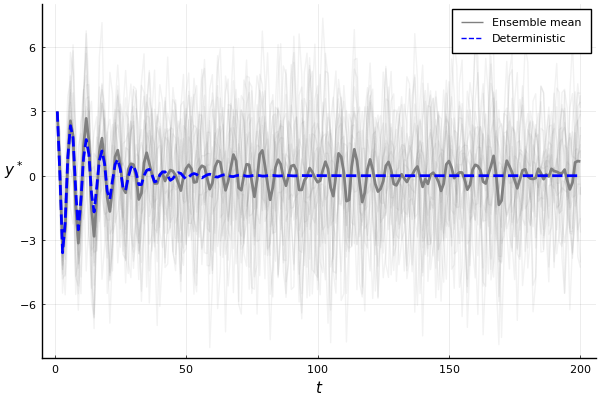

In [14]:
Σ = AR2_to_companion([0.6, -0.6], [0.6, -0.6])
plot_AR2(3*ones(3), Σ, 200, 1, row=1)
plot!(ylabel=L"y^*", yguidefontrotation=-90)

Plots for other initial values $y_0$ follow a similar pattern.

However, the bound on the SCJSR exceeds 1 in this case (as does the bound for the CJSR)

In [15]:
Σ = AR2_to_TAR([0.6, -0.6], [0.6, -0.6])
s = discreteswitchedsystem(Σ, G, X)
@show γ_cjsr = cjsr(s)
@show γ_scjsr = sosbound_γ(s, 2)

γ_cjsr = cjsr(s) = 1.118374537305998


γ_scjsr = sosbound_γ(s, 2) = 1.0954482078552243


1.0954482078552243